In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,SGD
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard,ReduceLROnPlateau
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import re
import gensim
import itertools
from nltk import ngrams
import warnings
warnings.filterwarnings('ignore')

## PreProcess Data

In [47]:
def process_csv(csv):
    df = pd.read_csv(csv)
    train_text ,train_tags = [] ,[]
    for i in tqdm(df['sentence_id'].unique()):
      train_text.append(df[df['sentence_id'] == i]['word'].tolist())
      train_tags.append(df[df['sentence_id'] == i]['tag'].tolist())
    return train_text,train_tags

In [48]:
train_text ,train_tags = process_csv('final_POS_data.csv')

100%|██████████| 36891/36891 [01:57<00:00, 313.18it/s]


In [50]:
train_text[0],train_tags[0]

(['جاء',
  'توقيع',
  'اتفاقية',
  'التعاون',
  'العسكرى',
  'بين',
  'مصر',
  'والسودان',
  'الثلاثاء',
  'الماضى',
  'فى',
  'الخرطوم',
  'ليدشن',
  'مرحلة',
  'جديدة',
  'فى',
  'تطوير',
  'العلاقات',
  'الإستراتيجية',
  'بين',
  'البلدين',
  'الشقيقين',
  'فى',
  'توقيت',
  'بالغ',
  'الأهمية',
  ',',
  'فالأوضاع',
  'الإقليمية',
  'والدولية',
  'ي'],
 ['Verb',
  'Noun',
  'Noun',
  'Noun',
  'Adjective',
  'Noun',
  'Proper Noun',
  'Proper Noun',
  'Noun',
  'Adjective',
  'Preposition',
  'Proper Noun',
  'Verb',
  'Noun',
  'Adjective',
  'Preposition',
  'Noun',
  'Noun',
  'Adjective',
  'Noun',
  'Noun',
  'Adjective',
  'Preposition',
  'Noun',
  'Adjective',
  'Noun',
  'Punctuation',
  'Noun',
  'Adjective',
  'Adjective',
  'Abbreviation'])

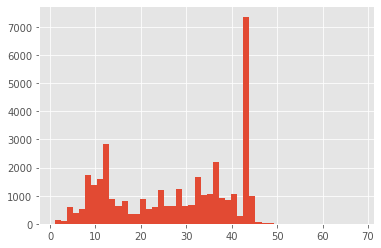

In [51]:
plt.style.use("ggplot")
plt.hist([len(s) for s in train_text], bins=50)
plt.show()

In [52]:
print('Max sentence length:',len(max(train_text, key=len)))

Max sentence length: 68


In [57]:
# Clean/Normalize Arabic Text
def clean_str(text):
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    text = text.replace('أ', 'ا')
    text = text.replace('إ', 'ا')
    text = text.replace('آ', 'ا')
    text = text.replace('ى', 'ي')

    return text.split()

In [58]:
for i in range(len(train_text)):
  train_text[i] = clean_str(' '.join(train_text[i]))

In [64]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [65]:
word_tokenizer = Tokenizer(oov_token = oov_tok)                    
word_tokenizer.fit_on_texts(train_text)  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1                  
X_encoded_train = word_tokenizer.texts_to_sequences(train_text)  

In [66]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tags)
Y_encoded_train = tag_tokenizer.texts_to_sequences(train_tags)

In [67]:
X_train = pad_sequences(X_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
Y_train = pad_sequences(Y_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

In [68]:
Y_train.shape

(36891, 50)

In [69]:
Y_train = to_categorical(Y_train)

In [70]:
Y_train.shape

(36891, 50, 35)

In [71]:
X_train, X_valid , Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 41)

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=41)

In [75]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_valid.shape))
print('Shape of output sequences: {}'.format(Y_valid.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (25085, 50)
Shape of output sequences: (25085, 50, 35)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (7379, 50)
Shape of output sequences: (7379, 50, 35)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (4427, 50)
Shape of output sequences: (4427, 50, 35)


In [76]:
NUM_CLASSES = Y_train.shape[2]
NUM_CLASSES

35

## Embedding Matrix

In [ ]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

--2021-06-09 21:16:37--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G  41.3MB/s    in 81s     

2021-06-09 21:17:58 (39.1 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [85]:
embedding_model = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')
embeddings = {}
for word,vector in zip(embedding_model.wv.vocab,embedding_model.wv.vectors):
    coefs = np.array(vector, dtype='float32')
    embeddings[word] = coefs
embeddings_weights = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embeddings_weights[i] = embedding_vector

## Create Model

In [87]:
model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH)))
model.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim,
                             input_length  = MAX_SEQUENCE_LENGTH,
                             weights = [embeddings_weights],
                             trainable     = True
))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           21471300  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 512)           1140736   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 512)           1574912   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 512)           1574912   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 512)           1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 35)            17955     
Total params: 27,354,727
Trainable params: 27,354,727
Non-trainable params: 0
__________________________________________

## Train Model

In [88]:
checkpoint = ModelCheckpoint('Bi_LSTM_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='min' , min_lr=0.00001)

In [90]:
result = model.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs = 50, batch_size= 128, shuffle = True,callbacks=[checkpoint,reducelr])

Epoch 1/50
196/196 [==============================] - 90s 295ms/step - loss: 1.0997 - accuracy: 0.7042 - val_loss: 0.2189 - val_accuracy: 0.9361

Epoch 00001: val_accuracy improved from -inf to 0.93606, saving model to Bi_LSTM_checkpoint.h5
Epoch 2/50
196/196 [==============================] - 55s 282ms/step - loss: 0.1615 - accuracy: 0.9537 - val_loss: 0.1028 - val_accuracy: 0.9690

Epoch 00002: val_accuracy improved from 0.93606 to 0.96903, saving model to Bi_LSTM_checkpoint.h5
Epoch 3/50
196/196 [==============================] - 55s 280ms/step - loss: 0.0603 - accuracy: 0.9831 - val_loss: 0.0847 - val_accuracy: 0.9749

Epoch 00003: val_accuracy improved from 0.96903 to 0.97493, saving model to Bi_LSTM_checkpoint.h5
Epoch 4/50
196/196 [==============================] - 55s 281ms/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 0.0857 - val_accuracy: 0.9763

Epoch 00004: val_accuracy improved from 0.97493 to 0.97625, saving model to Bi_LSTM_checkpoint.h5
Epoch 5/50
196/196 [=======

## Evaluate Model

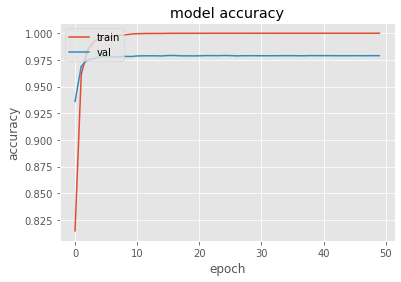

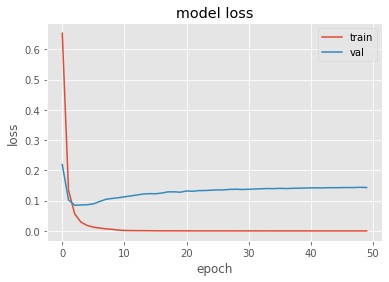

In [91]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [92]:
model.load_weights('Bi_LSTM_checkpoint.h5')

In [93]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

139/139 [==============================] - 2s 17ms/step - loss: 0.1204 - accuracy: 0.9795
Loss: 0.12044034153223038,
Accuracy: 0.9794849753379822


## Predict 

In [94]:
def classify(sentence):
  sentence = clean_str(sentence)
  seq = [word_tokenizer.texts_to_sequences(sentence)]
  pad_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
  pad_seq = np.squeeze(pad_seq,axis=-1)
  pred = np.squeeze(model.predict(pad_seq).argmax(-1))
  output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
  return output

In [97]:
sentence = "جون يحب البيت الأزرق في نهاية الشارع"
output = classify(sentence)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag)

[('جون', 'proper noun'), ('يحب', 'verb'), ('البيت', 'noun'), ('الأزرق', 'noun'), ('في', 'preposition'), ('نهاية', 'noun'), ('الشارع', 'noun')]
